# Basic Init

 **Imports**

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import tensorflow as tf
import glob
import pickle
import os
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose
from keras.models import Model, load_model
from keras import backend as K
from google.colab import drive
from keras import optimizers

Using TensorFlow backend.


**Connection to gdrive and file listing**

In [2]:
drive.mount('/content/gdrive')
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


In [0]:
base_path = 'gdrive/My Drive/projects/Brain MRI BTech Project/PreprocData/'

**List Resource**

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

In [0]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 299.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


# Dataset Handling

**MRI handling functions**

In [0]:
def get_rand_slice_list(data_shape):
  x_max, y_max, z_max = data_shape
  x_curr = randint((x_max/2)-(x_max/4), (x_max/2)+(x_max/4))
  y_curr = randint((y_max/2)-(y_max/4), (y_max/2)+(y_max/4))
  z_curr = randint((z_max/2)-(z_max/4), (z_max/2)+(z_max/4))
  return x_curr, y_curr, z_curr



def show_mri_slices_random(mri_data, explicit_pos=None):
  """ Function to display random image slices """
  '''Provision to give exact slice numbers'''
  '''Random numbers biased towards middle'''

  print('Data Shape = ',mri_data.shape)
  if explicit_pos==None:
    x_curr, y_curr, z_curr = get_rand_slice_list(mri_data.shape)
  else:
    x_curr, y_curr, z_curr = explicit_pos
  print('Data Positions = ',x_curr, y_curr, z_curr)
  slice_0 = mri_data[x_curr, :, :]
  slice_1 = mri_data[:, y_curr, :]
  slice_2 = mri_data[:, :, z_curr]
  print('Slice 1: value: ',x_curr)
  plt.imshow(slice_0.T, cmap='gray', origin=0)
  plt.show()
  print('Slice 2: value: ',y_curr)
  plt.imshow(slice_1.T, cmap='gray', aspect=0.5, origin=0)
  plt.show()
  print('Slice 3: value: ',z_curr)
  plt.imshow(slice_2.T, cmap='gray', aspect=0.5, origin=0)
  plt.show()
    
    
def get_mri_data(path):
  img_obj = nib.load(path)
  return img_obj.get_fdata()


def get_mri_data_scaler(path,scale_vals,type_mri):
  img_obj = nib.load(path)
  smax,smin = scale_vals[type_mri]
  curr_data = img_obj.get_fdata()
  curr_data = ((curr_data - smin)/(smax-smin))*smax
  return curr_data

def id_extract(stringpath):
  name_parts = stringpath.split(os.sep)
  name_parts.pop()
  dataset_name = name_parts.pop()
  return int(dataset_name[-2:])
  
def print_Details(dat_paths):
  for dat in dat_paths:
    print(dat['id'])
    for key,val in dat.items():
      if key != 'id':
        aaa = get_mri_data(val)
        print(key,aaa.shape,aaa.max(),aaa.min())
    

**Dataset Loading Function**

In [0]:
def load_MS_dataset(base_dataset_path):
  total_dataset = []
  patient_folders =glob.glob(base_dataset_path+'*/')
  patient_folders.sort()
  for curr_data_path in patient_folders:
    curr_dataset={}
    curr_dataset['id'] = id_extract(curr_data_path)
    curr_dataset['flair'] = glob.glob(curr_data_path+'/*flair.nii.gz')[-1]
    curr_dataset['t1'] =glob.glob(curr_data_path+'/*t1.nii.gz')[-1]
    curr_dataset['t2'] = glob.glob(curr_data_path+'/*t2.nii.gz')[-1]
    curr_dataset['label'] = glob.glob(curr_data_path+'/*label.nii.gz')[-1]
    total_dataset.append(curr_dataset)
    print(curr_dataset['id'])
    
  with open(base_dataset_path+'data_details.pickle', "rb") as data_details_file:
    dataset_details = pickle.load(data_details_file)
  
  return total_dataset, dataset_details
    

**Model Helper functions**

In [0]:
def dice_coef_modified(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
  
  
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient_loss(y_true, y_pred):
    return 1.0-dice_coef_modified(y_true, y_pred)

def binarise_lesion(lesion_data):
  lesion_data[lesion_data <= 0] = 0
  lesion_data[lesion_data > 0] = 1
  return lesion_data


def Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.to_int32(true_labels & pred_labels)
        union = tf.to_int32(true_labels | pred_labels)
        legal_batches = K.sum(tf.to_int32(true_labels), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    legal_labels = ~tf.debugging.is_nan(iou)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)


**Find Scaling Constants**

In [0]:
def scalervals(img_paths):
  flair_max=float('-inf')
  flair_min=float('inf')
  t1_max=float('-inf')
  t1_min=float('inf')
  t2_max=float('-inf')
  t2_min=float('inf')
  for dat in img_paths:
      print(dat['id'])
      curr_flair_data = get_mri_data(dat['flair'])
      curr_t1_data = get_mri_data(dat['t1'])
      curr_t2_data = get_mri_data(dat['t2'])
      
      
      curr_flair_max = np.max(curr_flair_data)
      curr_flair_min = np.min(curr_flair_data)
      if(curr_flair_max>flair_max):
        flair_max = curr_flair_max
      if(curr_flair_min<flair_min):
        flair_min = curr_flair_min
        
      curr_t1_max = np.max(curr_t1_data)
      curr_t1_min = np.min(curr_t1_data)
      if(curr_t1_max>t1_max):
        t1_max = curr_t1_max
      if(curr_t1_min<t1_min):  
        t1_min = curr_t1_min
      
      curr_t2_max = np.max(curr_t2_data)
      curr_t2_min = np.min(curr_t2_data)
      if(curr_t2_max>t2_max):
        t2_max = curr_t2_max
      if(curr_t2_min<t2_min):
        t2_min = curr_t2_min
      
  return {'flair': [flair_max, flair_min],'t1': [t1_max,t1_min],'t2': [t2_max,t2_min]}


# Autoencoder Architecture

**Main Model Function**

Model Details:
3D autoencoder



In [0]:
#Model Constants

model_input_size = (192, 512, 512, 1) #channels last
total_epochs=400
epochs_per_item=10
learning_rate = 0.0001

In [0]:
def build_model_3dautoencoder():
  model_Input = Input(shape=model_input_size)
  #Encoder
  Conv3D_layer = Conv3D(filters = 8, kernel_size = (3, 3, 3), activation='relu', padding='same')(model_Input)
  MaxPooling3D_layer = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(Conv3D_layer)
  Conv3D_layer = Conv3D(filters = 16, kernel_size = (3, 3, 3), activation='relu', padding='same')(MaxPooling3D_layer)
  MaxPooling3D_layer = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(Conv3D_layer)
  Conv3D_layer = Conv3D(filters = 32, kernel_size = (3, 3, 3), activation='relu', padding='same')(MaxPooling3D_layer)
  encoding_layer = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(Conv3D_layer)
  
  #decoder
  Conv3D_layer = Conv3D(filters = 32, kernel_size = (3, 3, 3), activation='relu', padding='same')(encoding_layer)
  UpSampling3D_layer = UpSampling3D(size=(2, 2, 2))(Conv3D_layer)
  Conv3D_layer = Conv3D(filters = 16, kernel_size = (3, 3, 3), activation='relu', padding='same')(UpSampling3D_layer)
  UpSampling3D_layer = UpSampling3D(size=(2, 2, 2))(Conv3D_layer)
  Conv3D_layer = Conv3D(filters = 8, kernel_size = (3, 3, 3), activation='relu', padding='same')(UpSampling3D_layer)
  UpSampling3D_layer = UpSampling3D(size=(2, 2, 2))(Conv3D_layer)
  decoding_layer = Conv3D(filters = 1, kernel_size = (3, 3, 3), activation='relu', padding='same')(UpSampling3D_layer)
  
  model_autoencoder_3d = Model(model_Input, decoding_layer)
  model_autoencoder_3d.compile(loss=[dice_coefficient_loss], optimizer=optimizers.Adam(lr=learning_rate))
  model_autoencoder_3d.summary()
  return model_autoencoder_3d


**Train and Test**

In [0]:
def train_lesion_Flair(model, dat_paths, tot_epochs, epoch_per_item):
  loopval=True
  while(loopval):
    for dat in dat_paths:
      if tot_epochs<0:
        loopval=False
        break
      print("Epochs left: ",tot_epochs)
      print("ID: ",dat['id'])
      curr_flair_data = get_mri_data(dat['flair'])
      curr_label_lesion_data = get_mri_data(dat['label'])
      if np.array_equal(curr_flair_data.shape,( 192, 512, 512)):
        curr_flair_data = np.reshape(curr_flair_data.astype('float32'), (1, 192, 512, 512, 1))
        curr_label_lesion_data = np.reshape(curr_label_lesion_data.astype('float32'), (1, 192, 512, 512, 1))                                            
        model.fit(curr_flair_data, curr_label_lesion_data, epochs=epoch_per_item)
        tot_epochs = tot_epochs - epoch_per_item
      else:
        print("size does not match.. Skipping..")
      
def test_lesion_Flair_show(model,dat_paths,num):
  num=num-1
  curr_flair_data = get_mri_data(dat_paths[num]['flair'])
  curr_flair_data_reshaped = np.reshape(curr_flair_data.astype('float32'), (1, 192, 512, 512, 1))
  curr_label_lesion_data = get_mri_data(dat_paths[num]['label'])
  curr_label_lesion_data_reshaped = np.reshape(curr_label_lesion_data.astype('float32'), (1, 192, 512, 512, 1))
  
  predict_lesion_data = model.predict(curr_flair_data_reshaped)
  predict_lesion_data = (predict_lesion_data.reshape((192, 512, 512))).astype(int)
  curr_slice_list = get_rand_slice_list((192, 512, 512))
  print('MRI')
  show_mri_slices_random(curr_flair_data,curr_slice_list)
  print('Label')
  show_mri_slices_random(curr_label_lesion_data,curr_slice_list)
  print('Predicted')
  predict_lesion_data = binarise_lesion(predict_lesion_data)
  show_mri_slices_random(predict_lesion_data,curr_slice_list)
  print("Max=",predict_lesion_data.max(),"Min=",predict_lesion_data.min())
  scores = model.evaluate(curr_flair_data_reshaped,curr_label_lesion_data_reshaped)
  print("Scores: ",scores)
  
  return predict_lesion_data


In [0]:
def save_output_mri(model,dat_paths,num):
  num=num-1
  curr_flair_data = get_mri_data(dat_paths[num]['flair'])
  curr_flair_data_reshaped = np.reshape(curr_flair_data.astype('float32'), (1, 192, 512, 512, 1))
  curr_label_lesion_data = get_mri_data(dat_paths[num]['label'])
  curr_label_lesion_data_reshaped = np.reshape(curr_label_lesion_data.astype('float32'), (1, 192, 512, 512, 1))
  predict_lesion_data = model.predict(curr_flair_data_reshaped)
  predict_lesion_data = (predict_lesion_data.reshape((192, 512, 512))).astype(int)
  curr_slice_list = get_rand_slice_list((192, 512, 512))
  predict_lesion_data = binarise_lesion(predict_lesion_data).astype(float)
 
  label_obj = nib.load(dat_paths[num]['label'])
  print(label_obj.get_data().shape)
  print(predict_lesion_data.shape)
  output_obj = nib.Nifti1Image(predict_lesion_data, label_obj.affine)
  nib.save(output_obj, 'output.nii.gz')
  


**Batching Support added**

In [0]:
def create_batch_flair(dat_paths, batch_size, curr_offset):
  total_size = len(dat_paths)
  curr_batch_flair=[]
  curr_batch_lesion=[]
  for curr_iter in range(batch_size):
    curr_id = (curr_offset + curr_iter) % total_size
    print('id: ',curr_id)
    curr_flair_data = get_mri_data(dat_paths[curr_id]['flair'])
    curr_label_lesion_data = curr_flair_data
    if np.array_equal(curr_flair_data.shape,( 192, 512, 512)):
        curr_flair_data = np.reshape(curr_flair_data.astype('float32'), (192, 512, 512, 1))
        curr_label_lesion_data = np.reshape(curr_label_lesion_data.astype('float32'), (192, 512, 512, 1))
        curr_batch_flair.append(curr_flair_data)
        curr_batch_lesion.append(curr_label_lesion_data)
    else:
      print("size does not match.. Skipping..")
  curr_batch_flair = np.array(curr_batch_flair)
  curr_batch_lesion = np.array(curr_batch_lesion)
  print('flair batch:',curr_batch_flair.shape)
  print('lesion batch',curr_batch_lesion.shape)
  new_offset = (curr_offset + batch_size) % total_size
  
  return new_offset, curr_batch_flair, curr_batch_lesion

def train_lesion_Flair_in_batches(model, dat_paths, tot_epochs, epoch_per_batch, batch_size):
  curr_offset = 0
  while(tot_epochs>0):
    print("Epochs left: ",tot_epochs)
    print('seed offset: ', curr_offset)
    curr_offset, curr_batch_flair, curr_batch_lesion = create_batch_flair(dat_paths, batch_size, curr_offset)
    model.fit(curr_batch_flair, curr_batch_lesion, epochs=epoch_per_batch)
    tot_epochs = tot_epochs - epoch_per_batch
  

# **Main PipeLine**

**Load Dataset and Generate Model**

In [11]:
dataset_paths,dataset_details = load_MS_dataset(base_path)
lesion3dAutoencoder = build_model_3dautoencoder()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 512, 512, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 192, 512, 512, 8)  224       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 96, 256, 256, 8)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 96, 256, 256, 16)  3472      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 48, 128, 128, 16)  0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 48, 128, 128, 32)  

**Model Training and Save**

In [0]:
train_lesion_Flair(lesion3dAutoencoder,dataset_paths,total_epochs,epochs_per_item)
lesion3dAutoencoder.save('my_model.h5')

Epochs left:  400
ID:  1
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.9946
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.9619
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.9537
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.9509
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.9491
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.9473
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.9453
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 0.9432
Epoch 9/10
1/1 [==============================] - 5s 5s/step - loss: 0.9412
Epoch 10/10
1/1 [==============================] - 5s 5s/step - loss: 0.9393
Epochs left:  390
ID:  2
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.9977
Epoch 2/10


KeyboardInterrupt: ignored

**Model Test**

MRI
Data Shape =  (192, 512, 512)
Data Positions =  53 260 250
Slice 1: value:  53


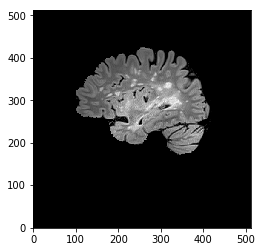

Slice 2: value:  260


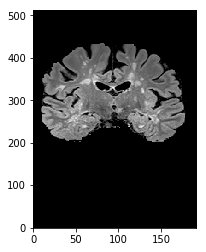

Slice 3: value:  250


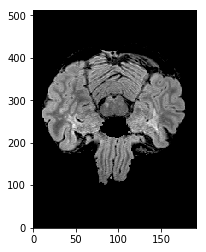

Label
Data Shape =  (192, 512, 512)
Data Positions =  53 260 250
Slice 1: value:  53


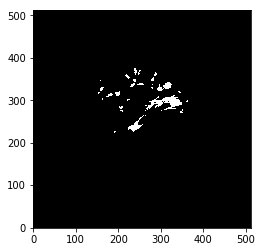

Slice 2: value:  260


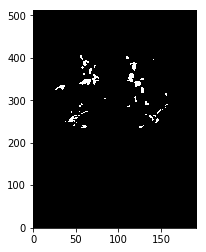

Slice 3: value:  250


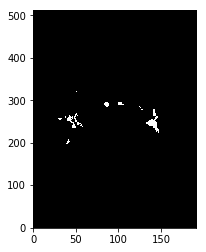

Predicted
Data Shape =  (192, 512, 512)
Data Positions =  53 260 250
Slice 1: value:  53


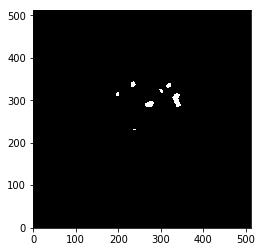

Slice 2: value:  260


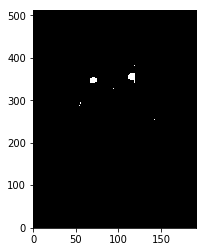

Slice 3: value:  250


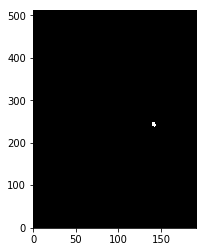

Max= 1 Min= 0
1/1 [==============================] - 2s 2s/step
Scores:  [-0.31793415546417236, 0.9939980506896973]


In [0]:
hhh=test_lesion_Flair_show(lesion3dAutoencoder,dataset_paths,6)

**Save ouput**

In [0]:
save_output_mri(lesion3dAutoencoder,dataset_paths,6)

**Load Model**

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


MRI
Data Shape =  (192, 512, 512)
Data Positions =  141 284 241
Slice 1: value:  141


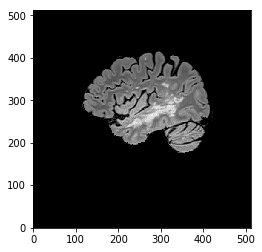

Slice 2: value:  284


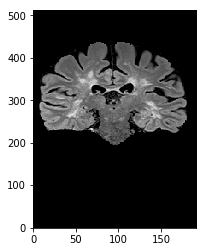

Slice 3: value:  241


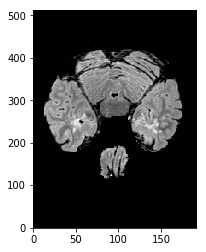

Label
Data Shape =  (192, 512, 512)
Data Positions =  141 284 241
Slice 1: value:  141


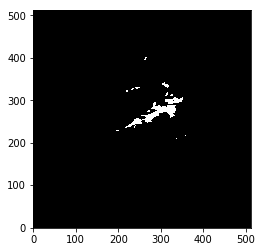

Slice 2: value:  284


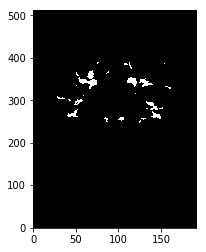

Slice 3: value:  241


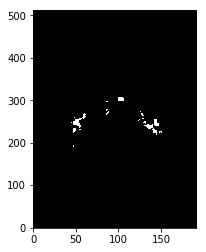

Predicted
Data Shape =  (192, 512, 512)
Data Positions =  141 284 241
Slice 1: value:  141


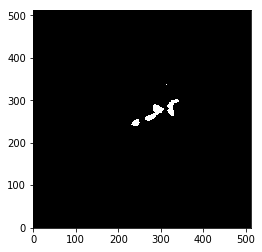

Slice 2: value:  284


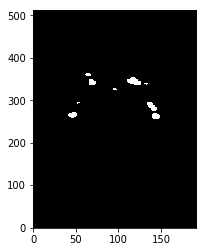

Slice 3: value:  241


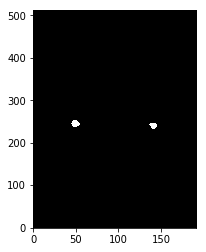

Max= 1 Min= 0


RuntimeError: ignored

In [13]:
autoencoder_model = load_model('my_model.h5')
hhh=test_lesion_Flair_show(autoencoder_model,dataset_paths,6)

# Generating output for each layer

In [17]:
def generate_all_layer_ouputs(model,dat_paths,num):
  num=num-1
  curr_flair_data = get_mri_data(dat_paths[num]['flair'])
  curr_flair_data_reshaped = np.reshape(curr_flair_data.astype('float32'), (1, 192, 512, 512, 1))
  curr_label_lesion_data = get_mri_data(dat_paths[num]['label'])
  curr_label_lesion_data_reshaped = np.reshape(curr_label_lesion_data.astype('float32'), (1, 192, 512, 512, 1))
  inp = model.input                                       # input placeholder
  outputs = [layer.output for layer in model.layers]          # all layer outputs
  functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function
  # Testing
  layer_outs = functor([curr_label_lesion_data_reshaped, 1.])
  print(layer_outs)
  
generate_all_layer_ouputs(autoencoder_model,dataset_paths,6)

InvalidArgumentError: ignored

# Try out Batching... Requires huge amt of VRAM

In [0]:
train_lesion_Flair_in_batches(lesion3dAutoencoder,dataset_paths,total_epochs,epochs_per_item, 2)

# **Kill session**

In [0]:
!pkill -9 -f ipykernel_launcher